## Code to access data/generate plots for electro-optical testing of the LSST sensors

By: Bela Abolfathi

(Some of these are redundant/vary slightly depending on what you're interested in studying, but I've included them anyway.)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
import os.path

from astropy.time import Time
from astropy.stats import sigma_clip
from datetime import datetime
from scipy import interpolate

import lsst.afw.image as afwImage


import lsst.eotest.image_utils as imutil
import lsst.eotest.sensor as sensorTest
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

### Get all bias frames for a particular RTM + sensor

In [3]:
def get_bias_frames(rtm_path, sensor):
    sflat_bias_frames = sorted(glob.glob(os.path.join(rtm_path, 'sflat_raft_acq/v0/*/' + sensor + '*bias*.fits')))
    flat_pair_bias_frames = sorted(glob.glob(os.path.join(rtm_path,'flat_pair_raft_acq/v0/*/' + sensor + '*bias*.fits')))
    fe55_bias_frames = sorted(glob.glob(os.path.join(rtm_path, 'fe55_raft_acq/v0/*/' + sensor + '*bias*.fits')))
    dark_bias_frames = sorted(glob.glob(os.path.join(rtm_path, 'dark_raft_acq/v0/*/' + sensor + '*bias*.fits')))
    qe_bias_frames = sorted(glob.glob(os.path.join(rtm_path, 'qe_raft_acq/v0/*/' + sensor + '*bias*.fits')))
    return(sflat_bias_frames, flat_pair_bias_frames, fe55_bias_frames, dark_bias_frames, qe_bias_frames)

In [4]:
base = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/'
RTM004_6106D = base + 'LCA-11021_RTM-004-Dev/6106D/'
sensor = 'S00/'

sflat_004_S00, flat_pair_004_S00, fe55_004_S00, dark_004_S00, qe_004_S00 = get_bias_frames(RTM004_6106D, sensor)

In [5]:
def analyze(filepath, amp, bias_method, bias_frame, **kwargs):

    im = MaskedCCD(filepath)[amp]
    oscan = makeAmplifierGeometry(filepath)
    
    fig, axs = plt.subplots(1,4, figsize=(18,10))
    axs = axs.ravel()
    
    
    lo0, hi0 = np.percentile(im.getImage().getArray(), (1,99))
    img0 = axs[0].imshow(im.getImage().getArray(), vmin=lo0, vmax=hi0, 
                          interpolation='none', origin='lower')
    
    bias_im = imutil.bias_image(im, oscan.serial_overscan, bias_method=bias_method, **kwargs)
    bias_arr = bias_im.getArray()
    lo1, hi1 = np.percentile(bias_arr, (1,99))
    img1 = axs[1].imshow(bias_arr, vmin=lo1, vmax=hi1, 
                          interpolation='none', origin='lower')
    
    bias_offset = imutil.unbias_and_trim(im, oscan.serial_overscan, bias_method=bias_method, bias_frame=None, **kwargs)
    lo2, hi2 = np.percentile(bias_offset.getImage().getArray(), (1,99))
    img2 = axs[2].imshow(bias_offset.getImage().getArray(), vmin=lo2, vmax=hi2, 
                          interpolation='none', origin='lower')
    
    ## Make a second copy
    deep_im = MaskedCCD(filepath)[amp]
    unbiased = imutil.unbias_and_trim(deep_im, oscan.serial_overscan, bias_method=bias_method, bias_frame=bias_frame)
    lo3, hi3 = np.percentile(unbiased.getImage().getArray(), (1,99))
    img3 = axs[3].imshow(unbiased.getImage().getArray(), vmin=lo3, vmax=hi3, 
                          interpolation='none', origin='lower')
    
    fmt = '%i'

    cbar0 = fig.colorbar(img0, ax=axs[0], format=fmt)
    cbar1 = fig.colorbar(img1, ax=axs[1], format=fmt)
    cbar2 = fig.colorbar(img2, ax=axs[2], format=fmt)
    cbar3 = fig.colorbar(img3, ax=axs[3], format=fmt)
    
    cbar0.ax.set_yticklabels(cbar0.ax.get_yticklabels(), fontsize=14)
    cbar1.ax.set_yticklabels(cbar1.ax.get_yticklabels(), fontsize=14)
    cbar2.ax.set_yticklabels(cbar2.ax.get_yticklabels(), fontsize=14)
    
    cbar2.set_label('Counts (ADU)', labelpad=28, fontsize=14, rotation=270)
    cbar2.ax.set_yticklabels(cbar2.ax.get_yticklabels(), fontsize=14)
    
    cbar3.set_label('Counts (ADU)', labelpad=28, fontsize=14, rotation=270)
    cbar3.ax.set_yticklabels(cbar3.ax.get_yticklabels(), fontsize=14)
    
    axs[0].set_xlabel('Column', fontsize=14)
    axs[0].set_ylabel('Row', fontsize=14)
    axs[1].set_xlabel('Column', fontsize=14)
    axs[2].set_xlabel('Column', fontsize=14)
    axs[3].set_xlabel('Column', fontsize=14)
    
    titles = ['Image', 'Overscan Model', 'Image - Overscan Model', 'Image - Overscan Model - Superbias']

    axs[0].set_title(titles[0], y=1.02, fontsize=16)
    axs[1].set_title(titles[1], y=1.02, fontsize=16)
    axs[2].set_title(titles[2], y=1.02, fontsize=16)
    axs[3].set_title(titles[3], y=1.02, fontsize=16)

    plt.tight_layout()
    plt.show()

In [6]:
amp = 1
oscan = makeAmplifierGeometry(sflat_004_S00[0]).serial_overscan
superbias = imutil.superbias(files=sflat_004_S00, overscan=oscan, bias_method='row', hdu=imutil.dm_hdu(amp))

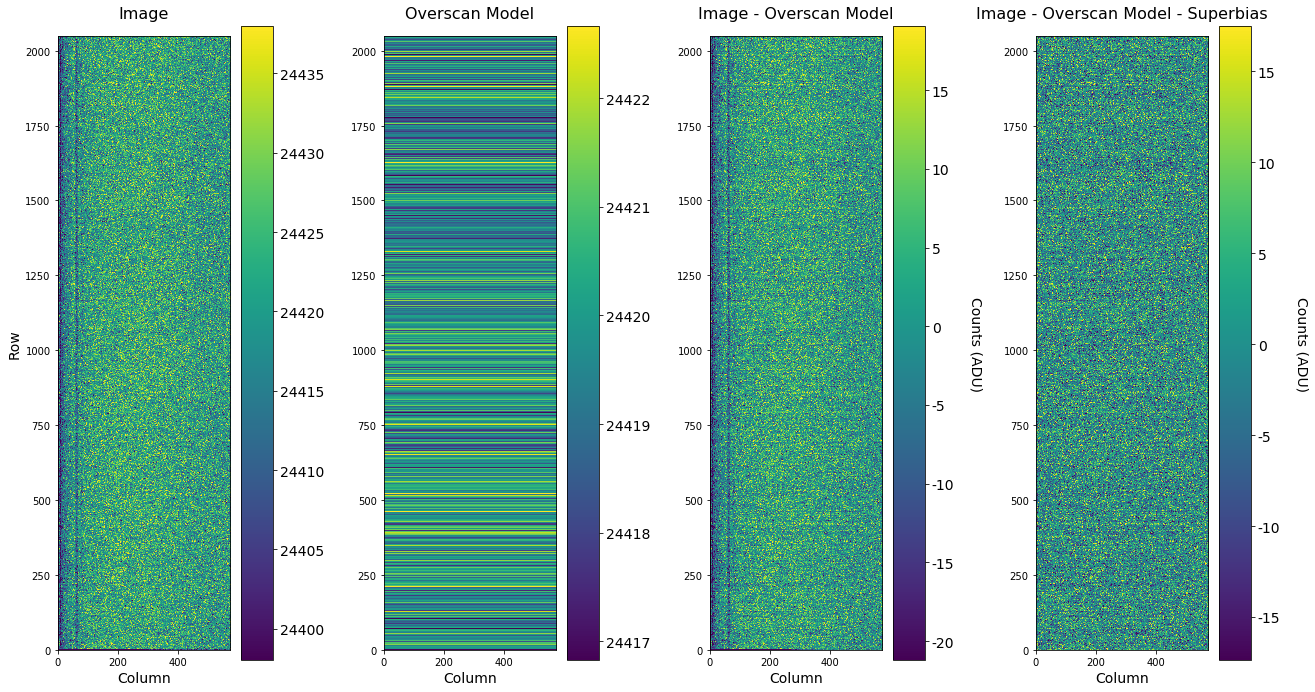

In [7]:
analyze(sflat_004_S00[0], amp=amp, bias_method='row', bias_frame=superbias)

### Compare offset correction methods to mean-per-row method:

In [8]:
def plot_offset_methods(filename, bias_method=None, **kwargs):
        
    fig, ax = plt.subplots(4,4, figsize=(20,15))
    ax = ax.ravel()

    im = MaskedCCD(filename)
    oscan = makeAmplifierGeometry(filename).serial_overscan
    
    all_amps = imutil.allAmps()

    for i, amp in enumerate(all_amps):
        im0 = im[amp].Factory(im[amp], oscan)
        imarr = im0.getImage().getArray()
        ny, nx = imarr.shape
        rows = np.arange(ny)
        row_bias = imutil.bias_row(im[amp], oscan)
        values = row_bias(np.arange(ny))
        lo, hi = np.percentile(values, (0.5, 100))
        if bias_method:
            biasim = imutil.bias_image(im[amp], oscan, bias_method=bias_method, **kwargs)
            other_values = biasim.getArray()[:,0]
            ax[i].plot(rows, other_values, '.', c='m', alpha=0.1, label=bias_method)
        ax[i].plot(rows, values, '.', c='b', alpha=0.1, label='row')
        ax[i].set_xlabel('Row number')
        ax[i].set_ylabel('Mean Counts [ADU]')
        ax[i].set_xlim(-30,2030)
        ax[i].set_ylim(lo - 5, hi + 5)
        ax[i].legend()
        ax[i].set_title('Amp {}'.format(amp), fontsize=14)
        ax[i].ticklabel_format(useOffset=False)
        
    fig.suptitle('{}'.format(os.path.basename(filename)), y=1.02, fontsize=18)

    plt.tight_layout()
    plt.show()

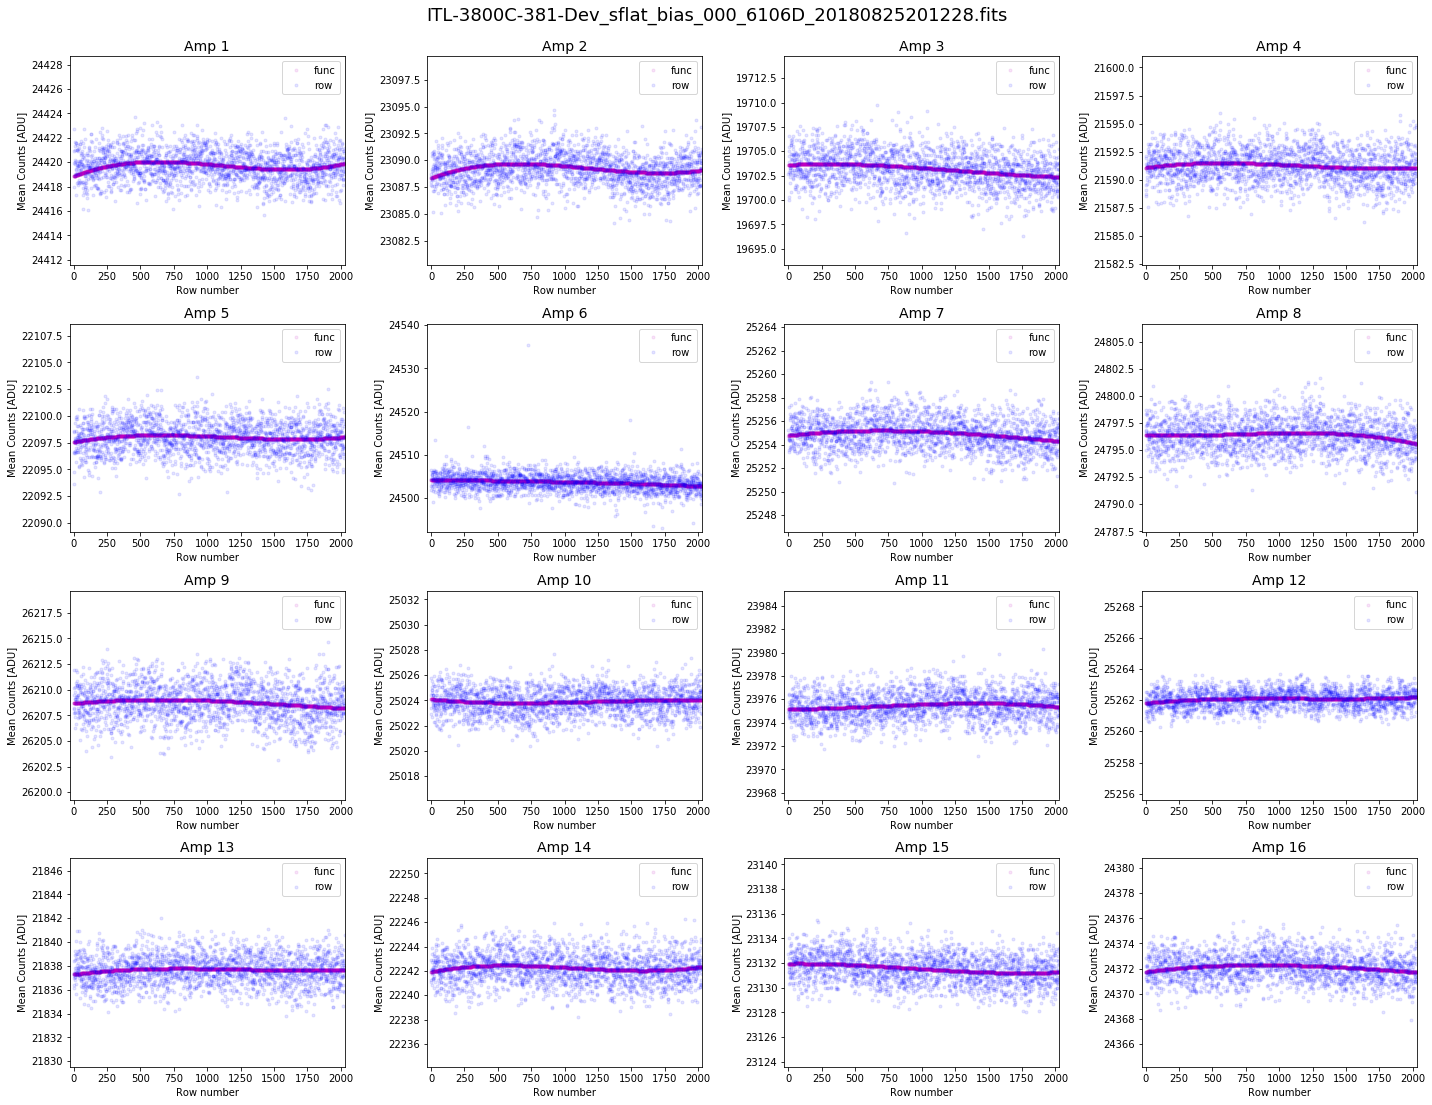

In [9]:
plot_offset_methods(sflat_004_S00[0], bias_method='func', fit_order=3)

### Compare all offset correction methods:

In [69]:
def plot_offset_methods(filename, **kwargs):
    
    fig, ax = plt.subplots(4,4, figsize=(20,15))
    ax = ax.ravel()

    im = MaskedCCD(filename)
    oscan = makeAmplifierGeometry(filename).serial_overscan
    
    all_amps = imutil.allAmps()

    for ii, amp in enumerate(all_amps):
        imarr = im[ii+1].Factory(im[amp], oscan).getImage().getArray()
        ny, nx = imarr.shape
        rows = np.arange(ny)
        mean = imutil.bias(im[amp], oscan)
        mpr = imutil.bias_row(im[amp], oscan)
        lin = imutil.bias_func(im[amp], oscan, fit_order=1)
        lin_fit = np.polyval(lin, rows)
        spline = imutil.bias_spline(im[amp], oscan, **kwargs)
        spline_fit = interpolate.splev(rows, spline)
        ax[ii].plot(rows, mpr(np.arange(ny)), '.', c='r', alpha=0.1, label='Mean per row')
        ax[ii].plot(rows, np.full(ny, mean), c='c', lw=2, ls='-', label='Mean')
        ax[ii].plot(rows, lin_fit, lw=3, ls='--', label='Linear')
        ax[ii].plot(rows, spline_fit, lw=3, label='Spline')
        ax[ii].set_xlabel('Row number')
        ax[ii].set_ylabel('Counts (ADU)')
        ax[ii].set_xlim(-30,2030)
        ax[ii].set_title('Amp {}'.format(ii+1), fontsize=14)
        ax[ii].legend(loc='best')
        ax[ii].ticklabel_format(useOffset=False)
        
   
    plt.tight_layout()
    plt.show()

In [70]:
plot_offset_methods(sflat_004_S00[0])

### Reproduce Youseke's bias trending:
https://confluence.slac.stanford.edu/display/LSSTCAM/RTM-005+Bias+and+noise+trending

In [18]:
def get_time(filename):
    return(int(os.path.splitext(os.path.basename(filename))[0].split('_')[-1]))

def get_mjd(filename):
    time = get_time(filename)
    t = Time(datetime(int(str(int(time))[:4]), int(str(int(time))[4:6]), int(str(int(time))[6:8]), 
                  int(str(int(time))[8:10]), int(str(int(time))[10:12]), int(str(int(time))[10:12])), 
         scale='utc')
    return(t.mjd)

In [109]:
def get_mean(filename, amp, bias_method=None, bias_frame=None, sigma=3):
    
    '''mask is True for clipped values'''
    
    im = MaskedCCD(filename)[amp]
    overscan = makeAmplifierGeometry(filename).serial_overscan
    
    if bias_method:
        im_corr = imutil.unbias_and_trim(im=im, overscan=overscan, bias_method=bias_method, bias_frame=bias_frame)
        data = im_corr.getImage().getArray()
        
    else:
        data = im.getImage().getArray()
        
    mask = sigma_clip(data,sigma=sigma).mask
    return np.mean(data[~mask])

In [124]:
def plot_mean(filenames, amp, bias_method=None, bias_frame=None, sigma=3):
    
    N = len(filenames)
    
    times = [get_mjd(filenames[i]) for i in range(N)]
    values = [get_mean(filenames[i], amp, bias_method, bias_frame, sigma) for i in range(N)]
    
    times = np.asarray(times)
    values = np.asarray(values)
    
    plt.plot(times, values, '.')
    plt.ylim(np.min(values) - 2, np.max(values + 2))
    plt.xlabel('MJD')
    plt.ylabel('Mean (ADU)')
    plt.show()

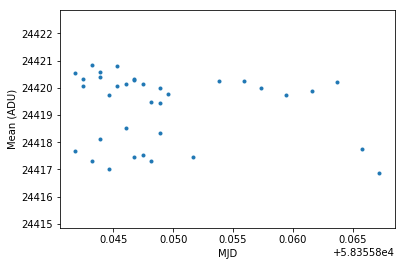

In [127]:
plot_mean(sflat_004_S00, 1)

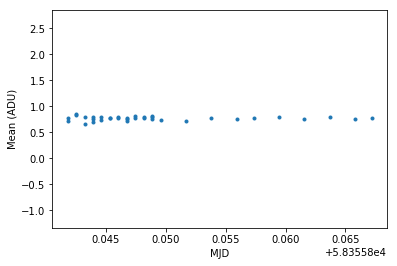

In [126]:
plot_mean(sflat_004_S00, 1, 'row')

In [136]:
def get_delta(filenames, amp, bias_method=None, bias_frame=None, sigma=3):
    
    N = len(filenames) - 1
    values = np.empty(N)
    times = np.empty(N)
    
    for i in range(N):
        values[i] = get_mean(filenames[i+1], amp, bias_method=bias_method, 
                              bias_frame=bias_frame, sigma=sigma) - get_mean(filenames[i], amp, 
                                                                            bias_method=bias_method, bias_frame=bias_frame, sigma=sigma)
        times[i] = 0.5 * (get_mjd(filenames[i+1]) + get_mjd(filenames[i]))
    
    return(times, values)

In [144]:
def get_all_deltas(rtm_path, sensor, amp, bias_method=None, bias_frame=None, sigma=3):
    
    sflats, flat_pairs, fe55, darks, qe = get_bias_frames(rtm_path, sensor)
    
    print('Getting flat pair deltas')
    flat_pair_times, flat_pair_diff = get_delta(flat_pairs, amp, bias_method, bias_frame, sigma)
    print('Getting qe deltas')
    qe_times, qe_diff = get_delta(qe, amp, bias_method, bias_frame, sigma)
    print('Getting fe55 deltas')
    fe55_times, fe55_diff = get_delta(fe55, amp, bias_method, bias_frame, sigma)
    print('Getting sflat deltas')
    sflat_times, sflat_diff = get_delta(sflats, amp, bias_method, bias_frame, sigma)
    print('Getting dark deltas')
    dark_times, dark_diff = get_delta(darks, amp, bias_method, bias_frame, sigma)
    
    return(flat_pair_times, flat_pair_diff, qe_times, qe_diff, fe55_times, fe55_diff, 
          sflat_times, sflat_diff, dark_times, dark_diff)

In [145]:
def plot_all_acq_modes(rtm_path, sensor, amp, bias_method=None, bias_frame=None, sigma=3, title=None):
    
    flat_pair_times, flat_pair_diff, qe_times, qe_diff, fe55_times, fe55_diff, sflat_times, sflat_diff, dark_times, dark_diff = get_all_deltas(rtm_path, sensor, amp, bias_method, bias_frame, sigma)
    
    plt.figure(figsize=(10,5))
    plt.scatter(flat_pair_times, flat_pair_diff, c='b', lw=0, label='flat_pair_raft_acq')
    plt.scatter(qe_times, qe_diff, c='g', lw=0, label='qe_raft_acq')
    plt.scatter(fe55_times, fe55_diff, c='r', lw=0, label='fe55_raft_acq')
    plt.scatter(sflat_times, sflat_diff, c='c', lw=0, label='sflat_raft_acq')
    plt.scatter(dark_times, dark_diff, c='y', lw=0, label='dark_raft_acq')
    plt.ylim(-10,12)
    plt.xlabel('MJD')
    plt.ylabel('Counts (ADU)')
    if title:
        plt.title(title)
    plt.legend(fontsize=11, loc='best')
    plt.show()

In [146]:
plot_all_acq_modes(RTM004_6106D, sensor, 1)

Getting flat pair deltas
Getting qe deltas
Getting fe55 deltas
Getting sflat deltas
Getting dark deltas


Getting flat pair deltas
Getting qe deltas
Getting fe55 deltas
Getting sflat deltas
Getting dark deltas


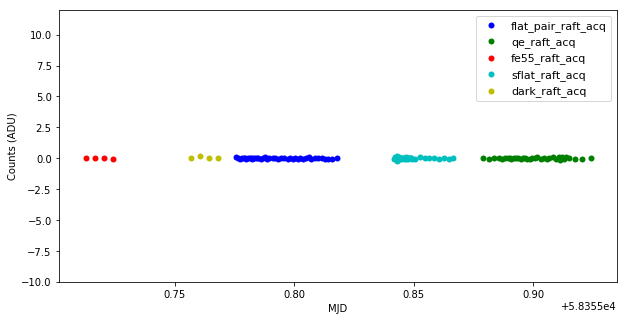

In [217]:
plot_all_acq_modes(RTM004_6106D, sensor, 1, 'spline')

### Look at the mean over rows/columns for superbiases made from bias frames from a specific acquisition type

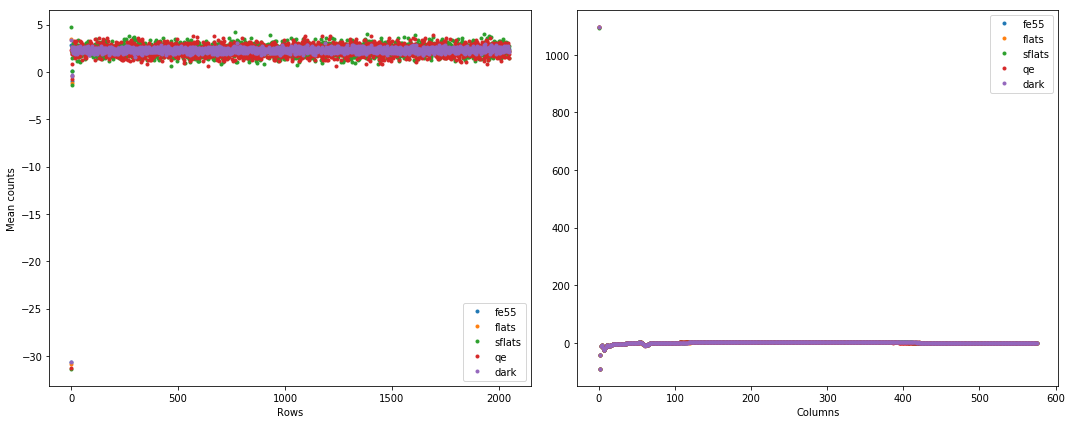

In [11]:
def project_superbias(rtm, sensor, hduidx, xlim1=None, xlim2=None):
    
    '''Look at projections of the superbias in the serial and parallel directions using all bias
    images (even ones that may be taken after bad/saturated images) and for all acquisition types.'''
    
    fe55, flat, sflat, qe, dark = get_bias_frames(rtm, sensor)
    dm_hduidx = imutil.dm_hdu(hduidx)

    bias_list = [fe55, flat, sflat, qe, dark]
    labels = ['fe55', 'flats', 'sflats', 'qe', 'dark']
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    
    for i in range(len(bias_list)):
        oscan = makeAmplifierGeometry(bias_list[i][0])
        superbias = imutil.superbias(bias_list[i], oscan.serial_overscan, hdu=dm_hduidx)
        imarr = superbias.getArray()
        ny, nx = imarr.shape
        rows = np.arange(ny)
        cols = np.arange(nx)
        mean_over_cols = np.mean(imarr, axis=1)
        mean_over_rows = np.mean(imarr, axis=0)
        ax1.plot(rows, mean_over_cols, '.', label=labels[i])
        ax2.plot(cols, mean_over_rows, '.', label=labels[i])

    ax1.set_xlabel('Rows')
    ax1.set_ylabel('Mean counts')
    ax2.set_xlabel('Columns')
    ax1.legend(loc=4)
    ax2.legend(loc=1)
    
    if xlim1:
        ax1.set_xlim(xlim1)
    if xlim2:
        ax2.set_xlim(xlim2)
    
    plt.tight_layout()
    plt.show()
    
project_superbias(rtm=RTM004_6106D, sensor=sensor, hduidx=amp)

### Look at performance of bias correction

    • Overplot serial/parallel projections of the bias-superbias

    • Plot mean and sigma of all images for each row/column

In [20]:
def overplots(bias_files, hduidx, bias_method, bias_frame, ylim_top=None, ylim_bottom=None, title=None):
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,10))
    
    nn = len(bias_files)
    
    ## not trimmed
    row_stats = np.empty((nn, 2048))
    col_stats = np.empty((nn, 576))
    
    oscan = makeAmplifierGeometry(bias_files[0])
    
    for ii, bias in enumerate(bias_files):
        
        ## offset and bias corrected image 
        biasim = MaskedCCD(bias)[hduidx]
        im = imutil.unbias_and_trim(biasim, oscan.serial_overscan, bias_frame=bias_frame, bias_method=bias_method)
            
        
        ## calculate average over columns
        yvals1 = np.mean(im.getImage().getArray(), axis=1)
        xvals1 = np.arange(len(yvals1))
                
        ## calculate average over rows
        yvals2 = np.mean(im.getImage().getArray(), axis=0)
        xvals2 = np.arange(len(yvals2))
        
        row_stats[ii] = yvals1
        col_stats[ii] = yvals2    
        
        ax1.plot(xvals1, yvals1, '.', ms=1)
        ax2.plot(xvals2, yvals2, '.', ms=1)

    ax1.set_xlabel('Row #', fontsize=14)
    ax1.set_ylabel('bias - super bias', fontsize=14)
    ax2.set_xlabel('Column #', fontsize=14)
    
    ax1.set_xlim(0,2050)
    ax2.set_xlim(0,580)

    if ylim_top:
        ax1.set_ylim(ylim_top)
        ax2.set_ylim(ylim_top)
     
        
    row_means = np.mean(row_stats, axis=0)
    row_sigs = np.std(row_stats, axis=0)
    col_means = np.mean(col_stats, axis=0)
    col_sigs = np.std(col_stats, axis=0)
        
    xvals1 = np.arange(row_stats.shape[1])
    xvals2 = np.arange(col_stats.shape[1])
        
    ## Plot
    
    ax3.plot(xvals1, row_means, '.', label='Mean', ms=3)
    ax3.plot(xvals1, row_sigs, '.', label='Sigma', ms=3)
    ax4.plot(xvals2, col_means, '.', label='Mean', ms=3)
    ax4.plot(xvals2, col_sigs, '.', label='Sigma', ms=3)
    
    ax3.set_xlim(0,2050)
    ax4.set_xlim(0,580)
    
    if ylim_bottom:
        ax3.set_ylim(ylim_bottom)
        ax4.set_ylim(ylim_bottom)
        
    ax3.set_xlabel('Row #', fontsize=14)
    ax3.set_ylabel('Counts', fontsize=14)
    ax4.set_xlabel('Column #', fontsize=14)
    ax3.legend()
    ax4.legend()
     
    if title:
        plt.suptitle(title, fontsize=16, y=1.02)
        
    plt.tight_layout()
    plt.show()
    
def verify_bias_images(rtm, sensor, hduidx):
    
    fe55, flat, sflat, qe, dark = get_bias_frames(rtm, sensor)
    acq = [fe55, flat, sflat, qe, dark]
    titles = ['fe55', 'flat', 'sflat', 'qe', 'dark']
    oscan = makeAmplifierGeometry(fe55[0])
    
    for i, mode in enumerate(acq):
        superbias = imutil.superbias(mode, oscan.serial_overscan, hdu=imutil.dm_hdu(hduidx), bias_method='spline')
        overplots(mode, hduidx, bias_method='spline', bias_frame=superbias, title=titles[i])
        
    return(fe55, flat, sflat, qe, dark)

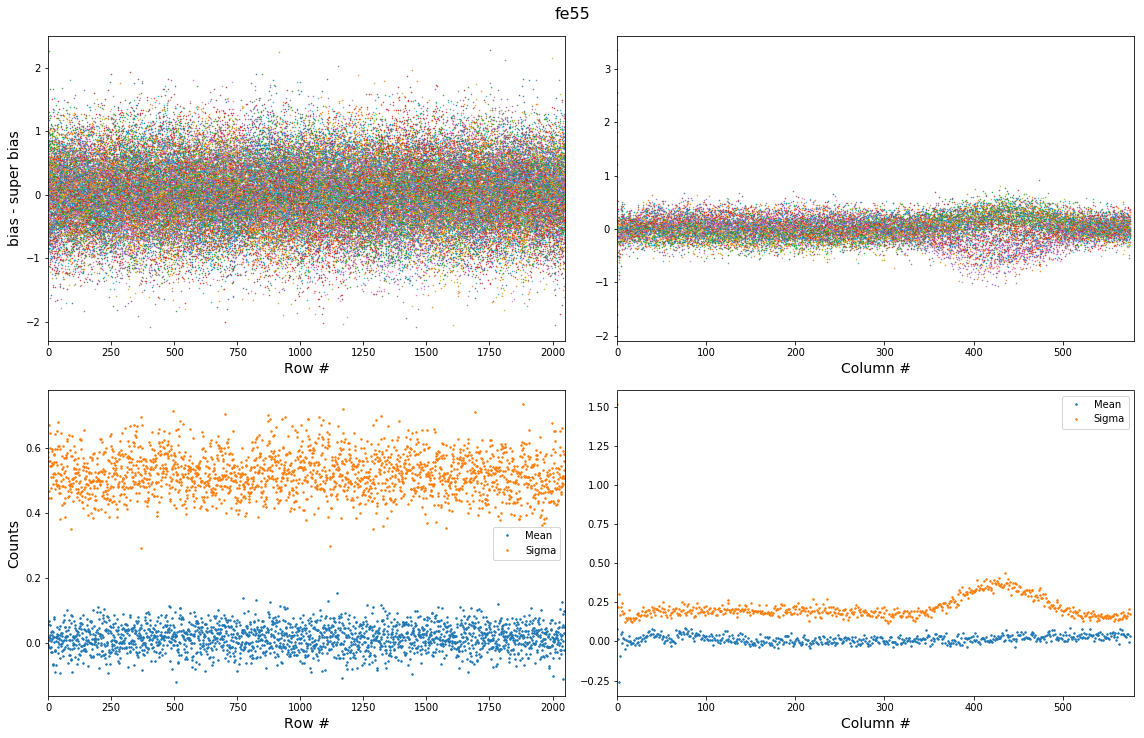

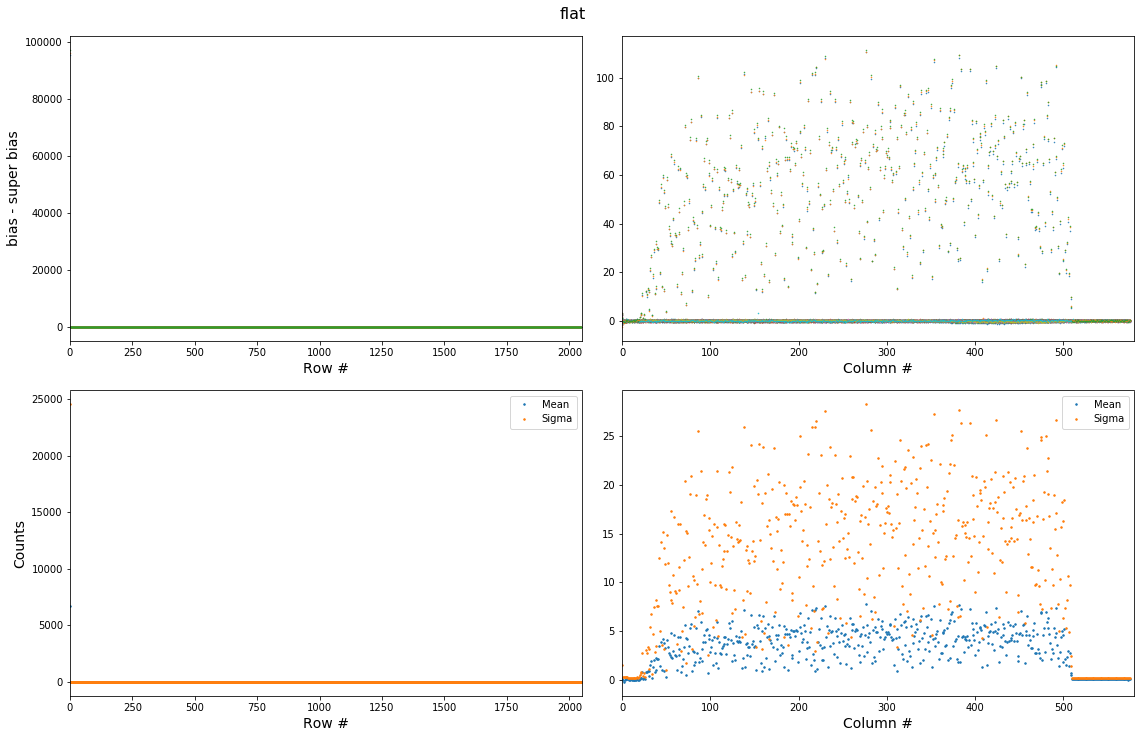

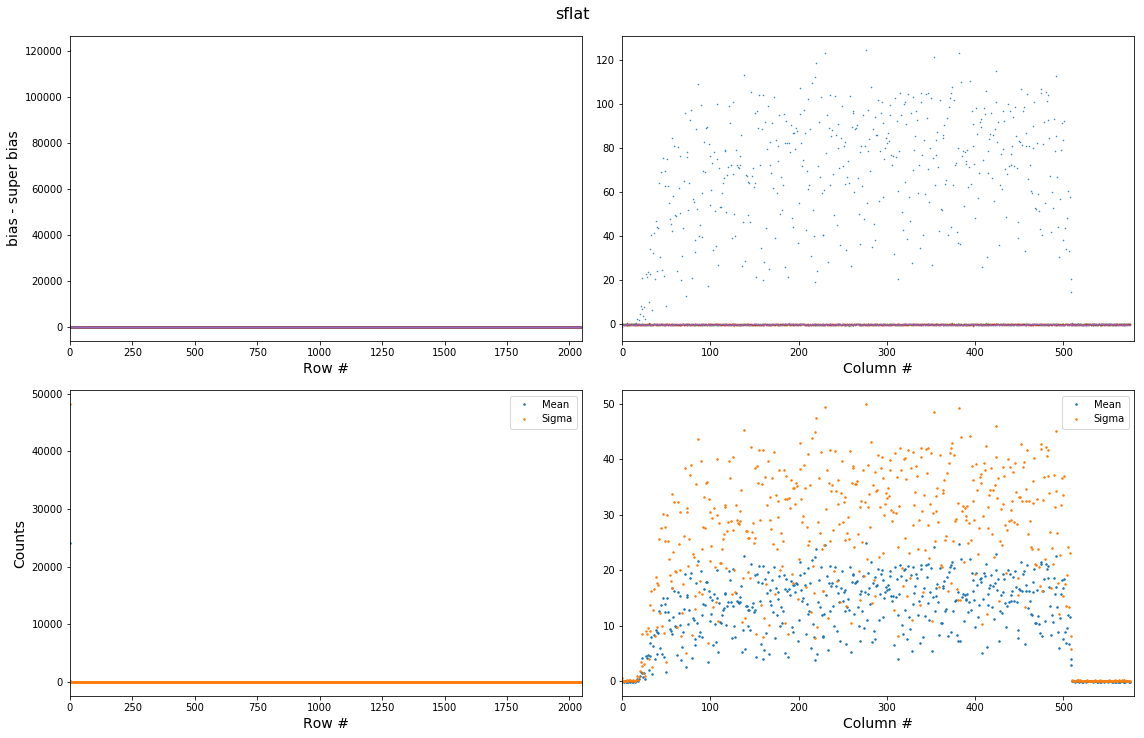

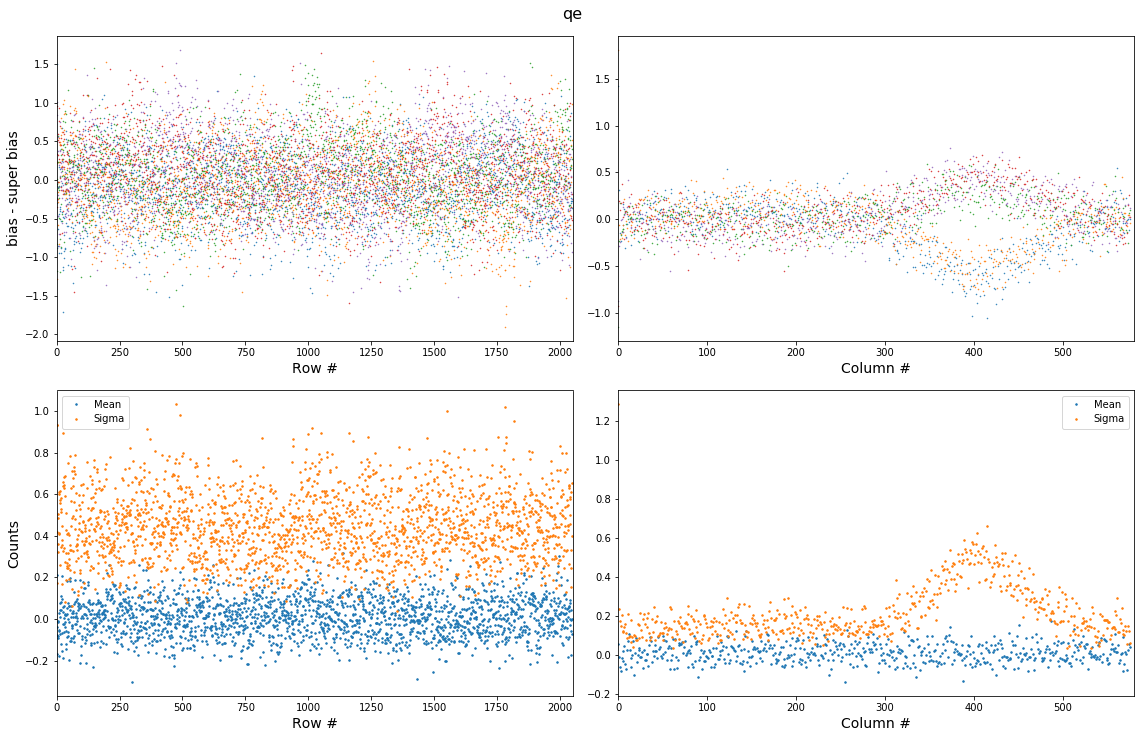

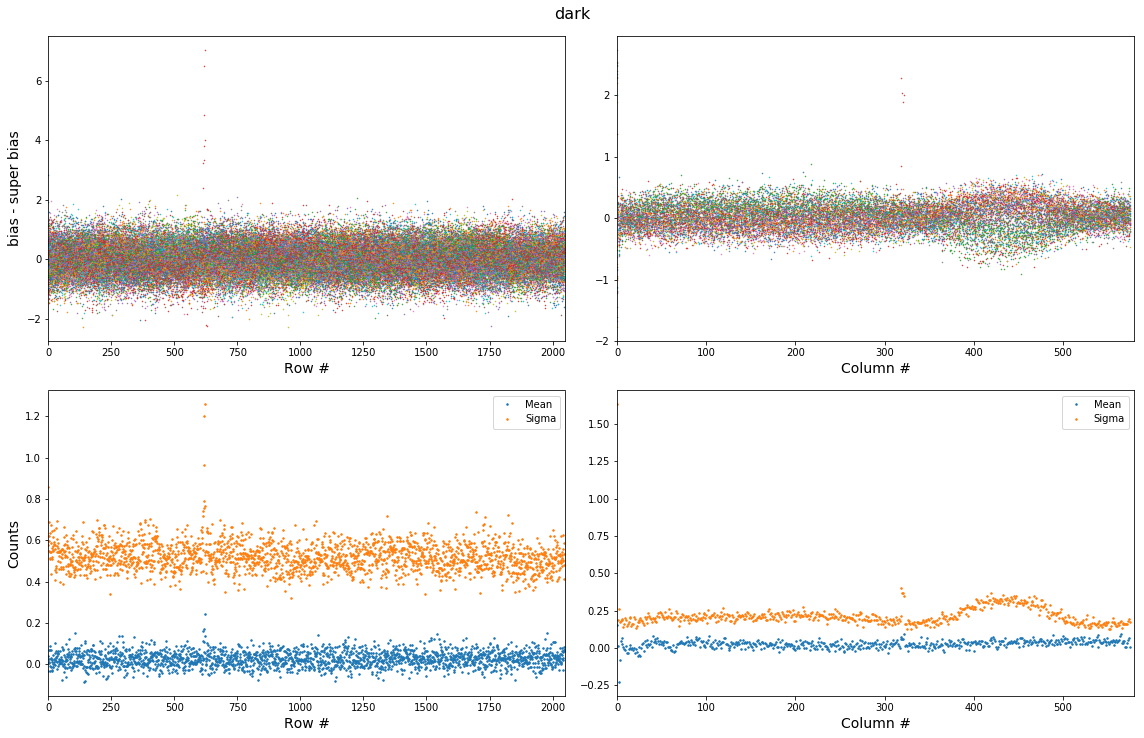

In [21]:
fe55, flat, sflat, qe, dark = verify_bias_images(RTM004_6106D, sensor, amp)

### Mean over columns/rows of bias and offset-corrected bias frames, with error bars

In [37]:
def mkImProfile(ax, im_file, bias_file, hduidx, axis=0, chunks=20, ylim=None, retPlot=True):
    """  Make a profile of an image[y,x], axis=0 is a projection of <y> vs. x, axis=1 is <x> vs. y
    """
    im = MaskedCCD(im_file)[hduidx]
    oscan = makeAmplifierGeometry(im_file)
    if bias_file:
        bias_frame = afwImage.ImageF(bias_file, imutil.dm_hdu(hduidx))
    else:
        bias_frame = None
    imarr = imutil.unbias_and_trim(im, oscan.serial_overscan, imaging=oscan.imaging, bias_frame=bias_frame, 
                                   bias_method='spline').getImage().getArray()
    
    otheraxis = [1,0]
    nbins = imarr.shape[otheraxis[axis]]
    xbins = np.arange(0,nbins,1)

    clipped = sigma_clip(imarr).data
    sc_mean, sc_std = np.mean(clipped, axis=axis), np.std(clipped, axis=axis)
    yerr = sc_std / np.sqrt(imarr.shape[axis])
    
    if retPlot:
        lines={'linestyle': 'None'}
        plt.rc('lines', **lines)
        ax.plot(xbins[::chunks], sc_mean[::chunks], 'ro', markersize=1, lw=0)
        ax.plot(xbins, 0 * xbins, ls='--', c='m', lw=5)
        profile = ax.errorbar(xbins[::chunks], sc_mean[::chunks], yerr=yerr[::chunks], ecolor='b', lw=0.5)
        ax.set_xlim(0,nbins)
        if ylim:
            ax.set_ylim(ylim)
        return profile
    else:
        return xbins,sc_mean,sc_std
    
def pltProfiles(im_file, bias_file, hduidx, ylim1=None, ylim2=None, chunks=20, retPlot=True):
    
    fig, axs = plt.subplots(1,2, figsize=(15,7))
    axs = axs.ravel()
    
    mkImProfile(axs[0], im_file=im_file, bias_file=bias_file, hduidx=hduidx, axis=0, chunks=chunks, ylim=ylim1, retPlot=retPlot)
    mkImProfile(axs[1], im_file=im_file, bias_file=bias_file, hduidx=hduidx, axis=1, chunks=chunks, ylim=ylim2, retPlot=retPlot)
    
    axs[0].set_xlabel('Columns', fontsize=14)
    axs[0].set_ylabel('Mean', fontsize=14)
    axs[1].set_xlabel('Rows', fontsize=14)
    
    
    plt.suptitle('{}'.format(os.path.basename(im_file)), fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

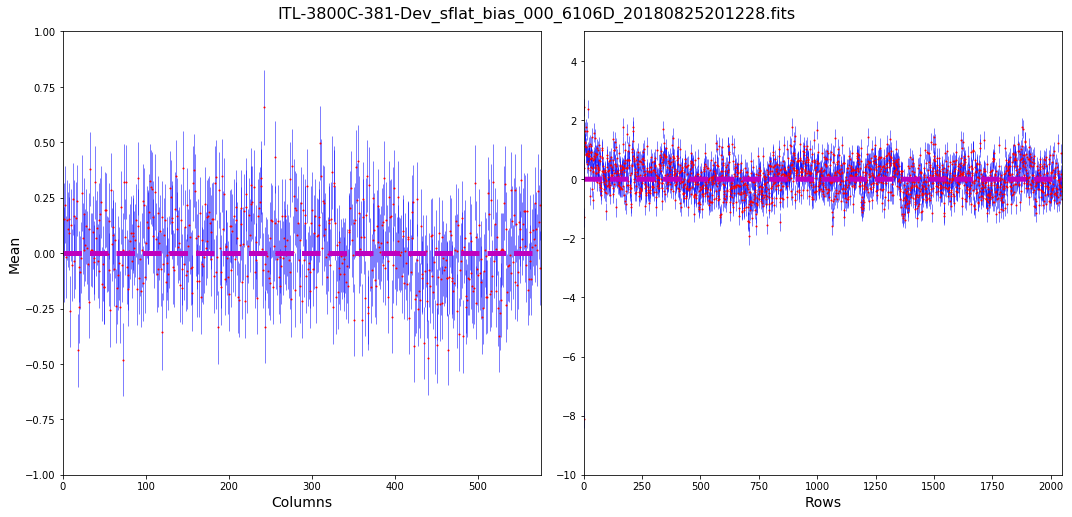

In [35]:
pltProfiles(sflat_004_S00[0], bias_file=superbias, hduidx=amp, chunks=1, ylim1=(-1,1), ylim2=(-10,5))

### Convert a lists of bias frames into a single list

In [37]:
def combine_bias_frames(bias_list):
    return([y for x in bias_list for y in x])

all_acq_biases = combine_bias_frames([fe55, flat, sflat, qe, dark])

In [56]:
## make a 16 HDU superbias file 
imutil.superbias_file(all_acq_biases, oscan, 'RTM004_6106D_S00_superbias', imaging=None, dxmin=5, dxmax=2, 
                    bias_method='row')

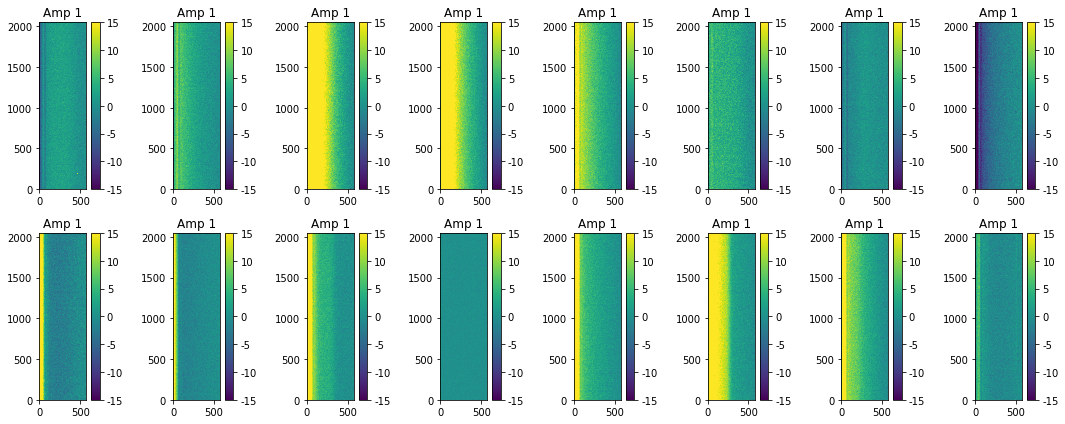

In [63]:
def plot_superbias(superbias_path):
    fig, axs = plt.subplots(2,8, figsize=(15,6))
    axs = axs.ravel()

    fmt = '%i'
    
    all_amps = imutil.allAmps()

    for i, dm_hdu in enumerate(all_amps):
        dat = afwImage.ImageF(superbias_path, dm_hdu).getArray()
        img = axs[i].imshow(dat, origin='low', interpolation='none', vmin=-15, vmax=15)
        cbar = fig.colorbar(img, ax=axs[i], format=fmt)
        axs[i].set_title('Amp {}'.format(amp))
        temp = dat
    plt.tight_layout()
    plt.show()

plot_superbias('RTM004_6106D_S00_superbias')

### Running superbiasTask

In [11]:
def get_biases_masks(base, raft, run, sensor):
    
    base_path = os.path.join(base, raft, run)
    
    fe55_bias_frames = sorted(glob.glob(os.path.join(base_path, 'fe55_raft_acq/v0/*/' + sensor + '/*bias*.fits')))
    flat_bias_frames = sorted(glob.glob(os.path.join(base_path, 'flat_pair_raft_acq/v0/*/' + sensor + '/*bias*.fits')))
    sflat_bias_frames = sorted(glob.glob(os.path.join(base_path, 'sflat_raft_acq/v0/*/' + sensor + '/*bias*.fits')))
    qe_bias_frames = sorted(glob.glob(os.path.join(base_path, 'qe_raft_acq/v0/*/' + sensor + '/*bias*.fits')))
    dark_bias_frames = sorted(glob.glob(os.path.join(base_path, 'dark_raft_acq/v0/*/' + sensor + '/*bias*.fits')))
        
    sensor_id = (os.path.splitext(os.path.split(fe55_bias_frames[0])[-1])[0]).split('_')[0] 
    
    rolloff_mask = sorted(glob.glob(os.path.join(base_path, 'fe55_raft_analysis/v0/*/' + sensor_id + '_*mask.fits')))[0]
    dark_mask = sorted(glob.glob(os.path.join(base_path, 'dark_defects_raft/v0/*/' + sensor_id + '_*mask.fits')))[0]
    traps_mask = sorted(glob.glob(os.path.join(base_path, 'traps_raft/v0/*/' + sensor, sensor_id + '_*mask.fits')))[0]
    bright_mask = sorted(glob.glob(os.path.join(base_path, 'bright_defects_raft/v0/*/' + sensor, 
                                                sensor_id + '_*mask.fits')))[0]
    
    bias_list = [fe55_bias_frames, flat_bias_frames, sflat_bias_frames, qe_bias_frames, dark_bias_frames]
    mask_files = [rolloff_mask, dark_mask, traps_mask, bright_mask]
    
    bias_files = [y for x in bias_list for y in x]

    return(bias_files, mask_files)

base = '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/'
raft = 'LCA-11021_RTM-008-Dev'
run = '5923D'
sensor = 'S00'
bias_method = 'row'
bitpix = -32

bias_files, mask_files = get_biases_masks(base, raft, run, sensor)

In [14]:
output_file = 'RTM-008-Dev_5923D_S00_superbias'
oscan = makeAmplifierGeometry(bias_files[0])
imutil.superbias_file(bias_files[::2], oscan.serial_overscan, outfile=output_file, bias_method=bias_method, bitpix=bitpix)

In [14]:
def get_sflat_exposures(base, raft, run, sensor):
    rtm_path = os.path.join(base, raft, run)
    lo = sorted(glob.glob(os.path.join(rtm_path, 'sflat_raft_acq/v0/*/' + sensor + '/*_flat_L*')))
    hi = sorted(glob.glob(os.path.join(rtm_path, 'sflat_raft_acq/v0/*/' + sensor + '/*_flat_H*')))
    return(lo, hi)

sflatL_files, sflatH_files = get_sflat_exposures(base, raft, run, sensor)

In [10]:
bias_files[0]

'/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_RTM-008-Dev/5923D/fe55_raft_acq/v0/39336/S00/E2V-CCD250-160-Dev_fe55_bias_000_5923D_20180515213415.fits'

In [22]:
sensor_id = 'E2V-CCD250-160-Dev'

sb_task = sensorTest.SuperbiasTask()
sb_task.config.output_dir = '.'
sb_task.run(sensor_id, sflatL_files, sflatH_files, mask_files, output_file)

### Look at outliers in images generated by superbiasTask

#### Read in the superbias (x-axis) and ratio (y-axis) data

In [18]:
superbias10 = MaskedCCD('RTM004_6106D_S00_superbias', mask_files=mask_files)[10]
trimmed_superbias10 = imutil.trim(superbias10, oscan.imaging).getImage().getArray()
ratio10 = afwImage.ImageF('E2V-CCD250-160-Dev_ratio_images.fits', 10).getArray()

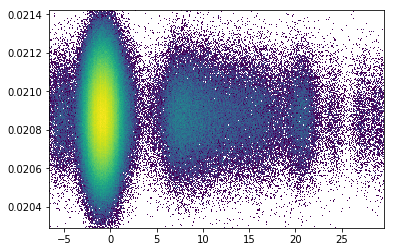

In [50]:
lo_s, hi_s = np.percentile(trimmed_superbias10, (0.05, 99.95))
lo_r, hi_r = np.percentile(ratio10, (0.05, 99.95))
plt.hist2d(trimmed_superbias10.flatten(), ratio10.flatten(), bins=([400,200]), range=((lo_s, hi_s), (lo_r, hi_r)), norm=mpl.colors.LogNorm())
plt.show()

In [19]:
def plot_outliers(axis, radius):
  
    try:
        outliers = np.abs(axis.getArray()) > radius
    except:
        outliers = np.abs(axis) > radius
    
    outside = np.argwhere(outliers)
    inside = np.argwhere(~outliers)
    
    plt.figure(figsize=(2,5))
    plt.plot(inside[:,1], inside[:,0], '.', ms=0.2, c='c', alpha=0.1)
    plt.plot(outside[:,1], outside[:,0], '.', c='m', ms=2)
    plt.xlim(0,576)
    plt.ylim(0,2048)
    plt.tight_layout()
    plt.show()

#### Look at where points beyond +/- 5 counts in superbias image lie on the sensor

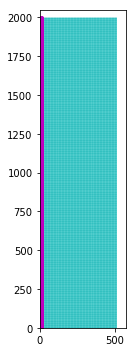

In [21]:
plot_outliers(trimmed_superbias10, 15)

#### If there are outliers on the ratio axis, this picks out points beyond +/- 0.0213 counts in the ratio image

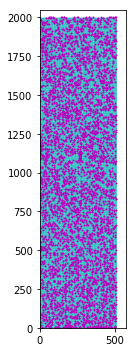

In [22]:
plot_outliers(ratio10, 0.0213)

Errors on the mean over columns, seem awfully small...

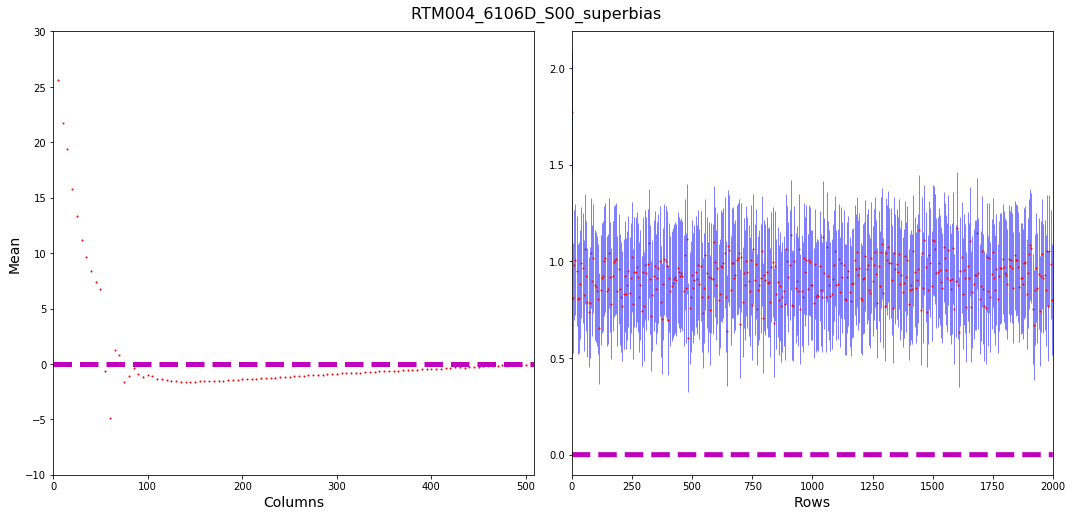

In [42]:
pltProfiles('RTM004_6106D_S00_superbias', bias_file=None, hduidx=10, ylim1=(-10,30), chunks=5)